![](https://wherobots.com/wp-content/uploads/2023/12/Inline-Blue_Black_onWhite.png)
</br>
<div style="display: flex;justify-content: flex-end; align-items: center; max-width: 100%; margin: auto; gap: 90px;">
    <!-- Main Content Box -->
    <div style="position: relative; display: flex; flex-direction: column; gap: 30px; 
                font-family: Arial, sans-serif; line-height: 1.6; max-width: 800px; 
                padding: 30px; color: #ffffff; background: #121212; 
                border-radius: 10px; box-shadow: 0px 0px 20px rgba(0, 255, 255, 0.0); 
                overflow: hidden;">
        <!-- Introductory Text -->
        <div style="position: relative; z-index: 2;">
               <h2 style="color: #00f5d4;">WherobotsAI Raster Inference - Object Detection</h2>
            <p style="font-size: 18px; color: #e0e0e0;">
                This example demonstrates an object detection model 
                with <strong>Raster Inference</strong> to identify <span style="color: #00f5d4; font-weight: bold;">
                marine infrastructure</span> (offshore wind farms and platforms) in satellite imagery.
            </p>
            <p style="font-size: 18px; color: #e0e0e0;">
                We will use a <strong>machine-learning model</strong> from <span style="color: #ff007f; font-weight: bold;">
                Satlas</span>, which was trained using imagery from the 
                <strong>European Space Agency’s Sentinel-2 satellites</strong>.
            </p>
        </div>
    </div>
    <!-- Right Section: Icons -->
    <div style="display: flex; flex-direction: column; align-items: flex-end; gap: 20px">
        <img src="./img/offshore_oil.png" 
             alt="Setup Icon" 
             style="width: 100%; height: 100%; border-radius: 8px;margin: 20px">
        <img src="./img/wind_farm.png" 
             alt="Wind Engine Offshore" 
             style="width: 100%; height: 100%; border-radius: 8px;margin: 20px ">
    </div>

</div>

</br>


</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Set Up The WherobotsDB Context</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
            Here we configure WherobotsDB to enable access to the necessary cloud object storage buckets with sample data.
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sedona.spark import SedonaContext
from pyspark.sql.functions import expr, size, col
from sedona.maps.SedonaKepler import SedonaKepler
from sedona.raster_utils.SedonaUtils import SedonaUtils
import json

config = SedonaContext.builder().appName('object-detection-batch-inference')\
    .getOrCreate()

sedona = SedonaContext.create(config)

</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Load Satellite Imagery Efficiently</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
<p style="font-size: 18px; color: #e0e0e0;">
            In this step, we load the satellite imagery to run <strong style="color: #00f5d4;">inference</strong> over.  
            These <strong>GeoTIFF images</strong> are ingested as <strong style="color: #00f5d4;">out-of-database or "out-db" rasters</strong> in 
            <strong>WherobotsDB</strong> and stored in the Spatial Catalog for easy access. Building out DB ensuring efficient storage and retrieval.
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>

In [20]:
df_raster_input = sedona.table(f"wherobots_pro_data.satlas.offshore_satlas")
df_raster_input.printSchema()

root
 |-- outdb_raster: raster (nullable = true)
 |-- path: string (nullable = true)
 |-- name: string (nullable = true)
 |-- footprint: geometry (nullable = true)



In [21]:
df_raster_input.count()

176000

</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Focus on a Coastal Region</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
            With <strong>176,000 images</strong> covering most of Earth's coastlines, let's choose an area to focus on.
        </p>
        <p style="font-size: 18px; color: #e0e0e0;">
            You can use the interactive map below to define a Region of Interest (ROI) as a <span style="color: #00f5d4; font-weight: bold;">polygon</span> or use the default ROI ( in red <span style="display: inline-block; width: 10px; height: 10px; background-color: #ba2762; border: 1px solid #000; margin-left: 5px;"></span>
) that is preloaded in the map. 
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>


In [5]:
from leafmap import Map

my_map = Map(zoom=7, center = (36.5, 122))
default_roi = {'type': 'Feature',
                       'properties': {},
                       'geometry': {'type': 'Polygon',
                        'coordinates': [[[120.959473, 35.918528],
                                        [120.959473, 36.820829],
                                        [123.046875, 36.820829],
                                        [123.046875, 35.918528],
                                        [120.959473, 35.918528]]]}}
my_map.add_geojson(default_roi, layer_name="Default AOI", style={"color": "#ba2762","fillOpacity": 0.5,"fillColor": "#ba2762","weight": 3,})
my_map

Map(center=[36.5, 122], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [23]:
if my_map.user_roi is None:
    my_map.user_roi = default_roi

In [24]:
feature_json = json.dumps(my_map.user_roi) # formats the python dictionary as a string so we can pass it to SQL
df_raster_sub = df_raster_input.where(
    expr(f"""ST_INTERSECTS(footprint, ST_GeomFromGeoJSON('{feature_json}'))""")
)

df_raster_sub.cache()
print(f"IMAGE COUNT: {df_raster_sub.count()}")
df_raster_sub.show(3, truncate=True)
df_raster_sub.createOrReplaceTempView("df_raster_input")
df_raster_sub.count()

IMAGE COUNT: 1224
+--------------------+--------------------+------------------+--------------------+
|        outdb_raster|                path|              name|           footprint|
+--------------------+--------------------+------------------+--------------------+
|OutDbGridCoverage...|s3://wherobots-be...|609889999-4-4.tiff|POLYGON ((122.338...|
|OutDbGridCoverage...|s3://wherobots-be...|864697964-6-9.tiff|POLYGON ((121.458...|
|OutDbGridCoverage...|s3://wherobots-be...|163816945-6-2.tiff|POLYGON ((121.445...|
+--------------------+--------------------+------------------+--------------------+
only showing top 3 rows



1224

</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Viewing Results</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;text-align: left;">
        <p style="font-size: 18px; color: #e0e0e0;">
           With our ROI defined we can see the footprints of the images in the ROI with the <code>SedonaKepler.create_map()</code> integration.
        </p>
        <p style="font-size: 18px; color: #e0e0e0;">
           Using <code>SedonaUtils.display_image()</code> we can view the images as well.
        </p>
    </div>
    <div style="display: inline-block; padding: 7px 16px; margin: 10px 0; border-radius: 4px; font-family: Arial, sans-serif, monospace; background-color: #1e293b; color: #81ecec; border-left: 6px solid #00cec9;">
        <strong style="text-transform: uppercase; letter-spacing: 1px;">Tip:</strong>  If you save the map to a html file using <code>kepler_map.save_to_html()</code>
    </div>
</div>
</br>

In [25]:
from sedona.maps.SedonaKepler import SedonaKepler

kepler_map = SedonaKepler.create_map()

SedonaKepler.add_df(kepler_map, df=df_raster_sub, name="Image Footprints")

kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Image Footprints': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…

,"rs_asimage(outdb_raster, 400)",as
0,,609889999-4-4.tiff
1,,864697964-6-9.tiff
2,,163816945-6-2.tiff

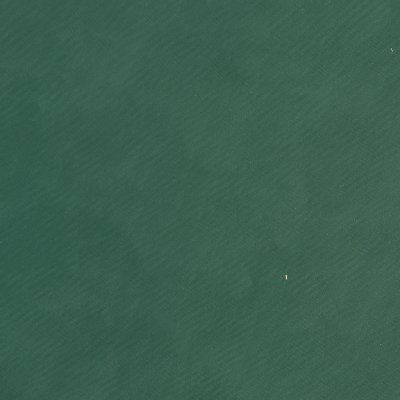
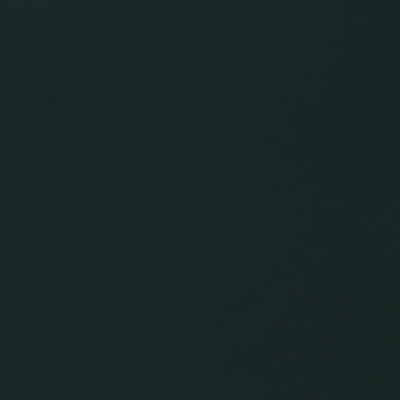
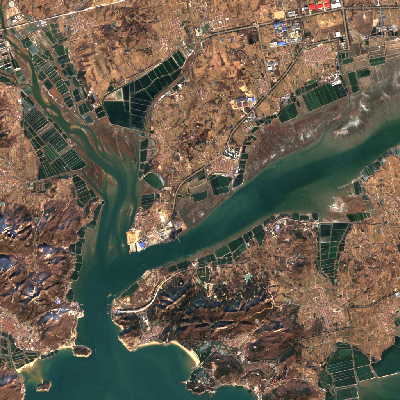

CPU times: user 32 ms, sys: 10.5 ms, total: 42.5 ms
Wall time: 17.6 s


In [26]:
htmlDf = sedona.sql(f"""SELECT RS_AsImage(outdb_raster, 250), name as FROM df_raster_input limit 5""")
SedonaUtils.display_image(htmlDf)

</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Run Predictions and Visualize Results</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
            To run predictions, we will specify the model we wish to use by the </code>model id</code>. Some models are pre-loaded and made available in 
            <strong>Wherobots Cloud</strong>. You can also load your own models, learn more on that process in the documentation <a href="https://docs.wherobots.com/latest/tutorials/wherobotsai/wherobots-inference/raster-inference-overview/?h=bring#bring-your-own-model-guide">here</a>. 
        </p>
        <p style="font-size: 18px; color: #e0e0e0;">
            Inference can be run using <strong>Wherobots' Spatial SQL functions</strong>, in this case: <code>RS_DETECT_BBOXES()</code>
        </p>
        <p style="font-size: 18px; color: #e0e0e0;">
            Here we generate predictions for all images in the AOI. The predictions output includes two labels, <code>1</code> for offshore wind turbines and <code>2</code> for offshore platfroms. 
            </br>
            </br>
        You can see that we filter and print some of the results to demonstrate how non-detects and positive detects results look.   
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>

In [27]:
model_id = 'marine-satlas-sentinel2'

predictions_df = sedona.sql(f"""
SELECT
  outdb_raster,
  name as image_name,
  detect_result.*
FROM (
  SELECT
    outdb_raster,
    name,
    RS_DETECT_BBOXES('{model_id}', outdb_raster) AS detect_result
  FROM
    df_raster_input
) AS detect_fields
""")

predictions_df.cache().count()
predictions_df.filter(size(col("labels")) == 0).show(3)
predictions_df.filter(size(col("labels")) == 1).show(3)
predictions_df.createOrReplaceTempView("predictions")

+--------------------+------------------+----------+-----------------+------+
|        outdb_raster|        image_name|bboxes_wkt|confidence_scores|labels|
+--------------------+------------------+----------+-----------------+------+
|OutDbGridCoverage...|609889999-4-4.tiff|        []|               []|    []|
|OutDbGridCoverage...|864697964-6-9.tiff|        []|               []|    []|
|OutDbGridCoverage...|864697964-2-9.tiff|        []|               []|    []|
+--------------------+------------------+----------+-----------------+------+
only showing top 3 rows

+--------------------+-------------------+--------------------+-----------------+------+
|        outdb_raster|         image_name|          bboxes_wkt|confidence_scores|labels|
+--------------------+-------------------+--------------------+-----------------+------+
|OutDbGridCoverage...|1084034835-9-8.tiff|[POLYGON ((120.73...|      [0.7774666]|   [2]|
|OutDbGridCoverage...| 864697964-3-9.tiff|[POLYGON ((121.21...|      [0.9



</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Run Predictions And Visualize Results</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
            Since we ran inference across a lot of coastline, many scenes don't contain wind farms and don't have positive detections. Now that we've generated predictions using our model over our satellite imagery, we can filter the geometries by confidence score with <code>RS_FILTER_BOX_CONFIDENCE</code> and by the integer label representing offshore wind farms, <code>1</code>, to locate predicted offshore wind farms (label <code>2</code> is the integer label representing offshore platforms).
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>

In [28]:
filtered_predictions = sedona.sql(f"""
  SELECT
    outdb_raster,
    image_name,
    filtered.*
  FROM (
    SELECT
      outdb_raster,
      image_name,
      RS_FILTER_BOX_CONFIDENCE(bboxes_wkt, confidence_scores, labels, 0.65) AS filtered
    FROM
      predictions
  ) AS temp
    WHERE size(filtered.max_confidence_bboxes) > 0
    AND 
        array_contains(filtered.max_confidence_labels, '1')
""")
filtered_predictions.createOrReplaceTempView("filtered_predictions")


</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Prepare Results</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
            Our final step before plotting our prediction results is to convert our table from a structure where each row represents all of a raster scene's predictions to a format where each row represents one predicted bounding box. </br>To do this, we combine our list columns with <code>arrays_zip</code> and then use <code>explode</code> to convert lists to rows. To convert our string column representing a geometry into a <code>GeometryType</code> column, we use <code>ST_GeomFromWKT</code> so we can plot it with <code>SedonaKepler</code>.
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>

In [29]:
exploded_df = sedona.sql("""
SELECT
    outdb_raster,
    image_name,
    exploded.*
FROM (
    SELECT
        outdb_raster,
        image_name,
        explode(arrays_zip(max_confidence_bboxes, max_confidence_scores, max_confidence_labels)) AS exploded
    FROM
        filtered_predictions
) temp
""")
df_exploded = exploded_df.withColumn("geometry", expr("ST_GeomFromWkt(max_confidence_bboxes)")).drop("max_confidence_bboxes")
print(df_exploded.cache().count())
df_exploded.show()

593
+--------------------+-------------------+---------------------+---------------------+--------------------+
|        outdb_raster|         image_name|max_confidence_scores|max_confidence_labels|            geometry|
+--------------------+-------------------+---------------------+---------------------+--------------------+
|OutDbGridCoverage...|2015411785-6-7.tiff|             0.967076|                    2|POLYGON ((121.456...|
|OutDbGridCoverage...|2015411785-6-7.tiff|            0.9071286|                    1|POLYGON ((121.471...|
|OutDbGridCoverage...|2015411785-6-7.tiff|            0.9035683|                    2|POLYGON ((121.461...|
|OutDbGridCoverage...|2015411785-7-6.tiff|            0.9934521|                    2|POLYGON ((121.655...|
|OutDbGridCoverage...|2015411785-7-6.tiff|            0.9925639|                    1|POLYGON ((121.604...|
|OutDbGridCoverage...|2015411785-7-6.tiff|            0.9900338|                    2|POLYGON ((121.660...|
|OutDbGridCoverage...|20

With this exploded result where each row has a Geometry Type in the geometry column, we can plot the bounding box results with SedonaKepler.

In [30]:
from sedona.maps.SedonaKepler import SedonaKepler

kepler_map = SedonaKepler.create_map()

SedonaKepler.add_df(kepler_map, df=df_exploded.drop("outdb_raster"), name="Wind Farm Detections")
kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Wind Farm Detections': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…


</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Select a Footprint and Review the Image</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
        Select one of the detected <strong>footprints</strong> from the map above. 
        Copy the name of a detected bounding box and paste it into the query below 
        to retrieve the corresponding image.
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>
<div style="display: inline-block; padding: 7px 16px; margin: 10px 0; border-radius: 4px; font-family: Arial, sans-serif, monospace; background-color: #1e293b; color: #81ecec; border-left: 6px solid #00cec9;">
        <strong style="text-transform: uppercase; letter-spacing: 1px;">Remember:</strong>  If you changed the ROI at the begining the <code>image_name</code> below might not be found.
    </div>

,"rs_asimage(outdb_raster, 500)",name
0,,2015411785-5-6.tiff

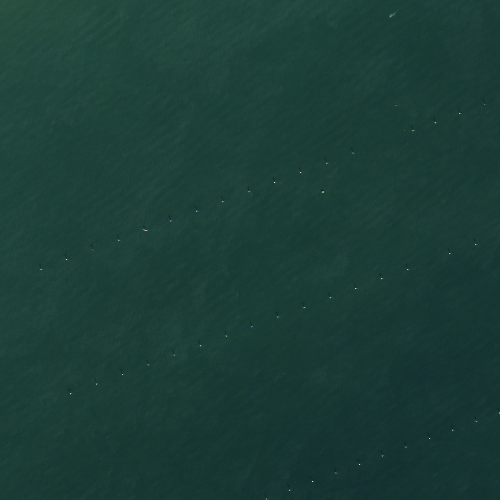

CPU times: user 14.2 ms, sys: 0 ns, total: 14.2 ms
Wall time: 883 ms


In [32]:
image_name = '2015411785-5-6.tiff'
htmlDf = sedona.sql(f"""SELECT RS_AsImage(outdb_raster, 500), name FROM df_raster_input WHERE name = '{image_name}' """)
SedonaUtils.display_image(htmlDf)

</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Python API for wherobots.inference </h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
            If you prefer python, wherobots.inference offers a module for registering the SQL inference functions as python functions. Below we run the same inference as before with `RS_DETECT_BBOXES`. 
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>

In [ ]:
from wherobots.inference.engine.register import create_object_detection_udfs
from pyspark.sql.functions import col
rs_detect, rs_threshold_geoms =  create_object_detection_udfs(batch_size = 10, sedona=sedona)
df = df_raster_input.withColumn("detect_result", rs_detect(model_id, col("outdb_raster"))).select(
                               "outdb_raster",
                               col("detect_result.bboxes_wkt").alias("bboxes_wkt"),
                               col("detect_result.confidence_scores").alias("confidence_scores"),
                               col("detect_result.labels").alias("labels")
                           )
df.show()